# Adhering to constraints

This notebook explains our approach to `smallness regularization`, with the goal of adhering to prior knowledge of topography we're aiming to recover. In the scenario of a sediment-basement contact inversion, if we know the basement depth at a few points from drill holes or seismic data, we want the inverted results to adhere to these points, which we refer to as `constraints`. 

Again, we will use the same synthetic data from the past two user guides, but add a little long wavelength noise to it to help show the effectiveness of our regularization. 

## Import packages

In [9]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import logging

import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    inversion,
    plotting,
    regional,
    synthetic,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

Sample the starting topography at 10 random locations and regrid with those sampled values. This simulates only knowing the depth to this topography at 10 boreholes.

In [5]:
# set grid parameters
spacing = 500
region = (0, 40000, 0, 30000)

(
    true_topography,
    _,
    _,
    _,
) = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    # topography_coarsen_factor=2,
    # topography_percent_noise=0.02,
)

# create lower synthetic topography data
lower_topography = synthetic.synthetic_topography_regional(
    spacing,
    region,
    scale=1,
    yoffset=-1000,
)

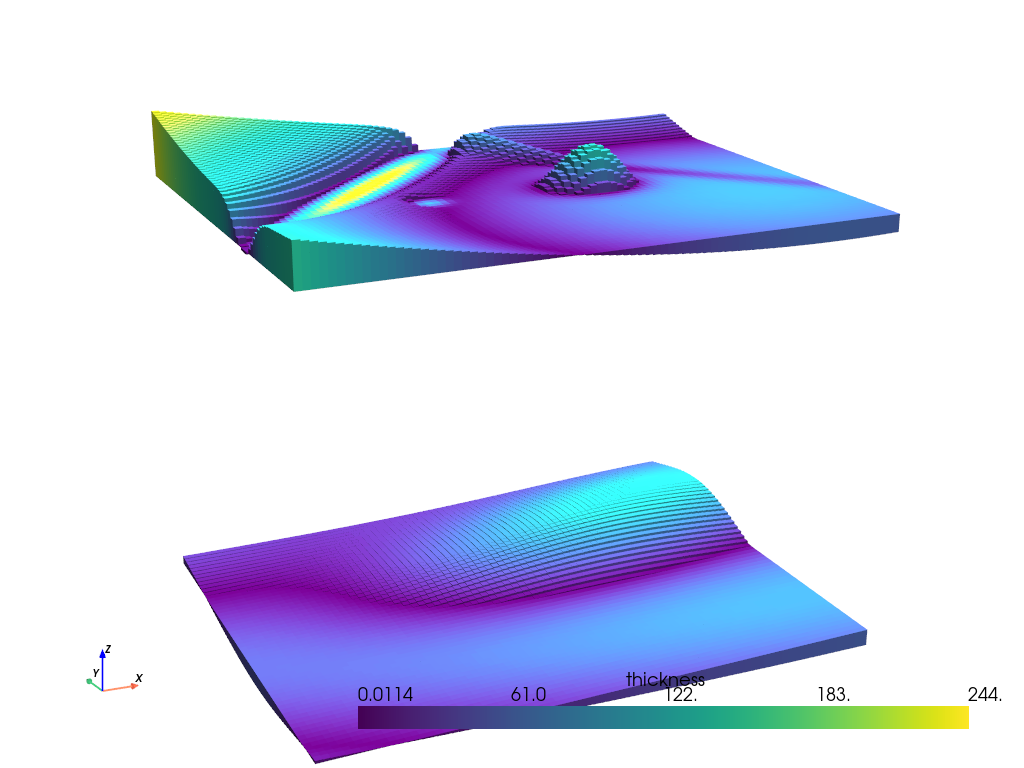

In [8]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
true_zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    true_topography >= true_zref,
    true_density_contrast,
    -true_density_contrast,
)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    true_zref,
    density=density_grid,
)

# the density contrast is between lower crust (~3100 kg/m3) and rock (~2670 kg/m3)
density_contrast = 3100 - 2670
zref = lower_topography.values.mean()

density_grid = xr.where(lower_topography >= zref, density_contrast, -density_contrast)
lower_prisms = utils.grids_to_prisms(
    lower_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    [prisms, lower_prisms],
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [12]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1001,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["upper_surface_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# forward gravity of lower surface prisms
grav_df["lower_surface_grav"] = lower_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df["gravity_anomaly"] = grav_df.upper_surface_grav + grav_df.lower_surface_grav
grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly
0,0.0,0.0,1001.0,6.966073,-0.045074,6.920999
1,0.0,500.0,1001.0,8.535965,-0.049696,8.486269
2,0.0,1000.0,1001.0,8.802495,-0.055773,8.746722
3,0.0,1500.0,1001.0,8.723351,-0.063154,8.660197
4,0.0,2000.0,1001.0,8.519803,-0.071496,8.448307
...,...,...,...,...,...,...
4936,30000.0,38000.0,1001.0,2.832952,0.558197,3.391148
4937,30000.0,38500.0,1001.0,2.816434,0.529278,3.345712
4938,30000.0,39000.0,1001.0,2.765486,0.491156,3.256643
4939,30000.0,39500.0,1001.0,2.607967,0.442645,3.050612


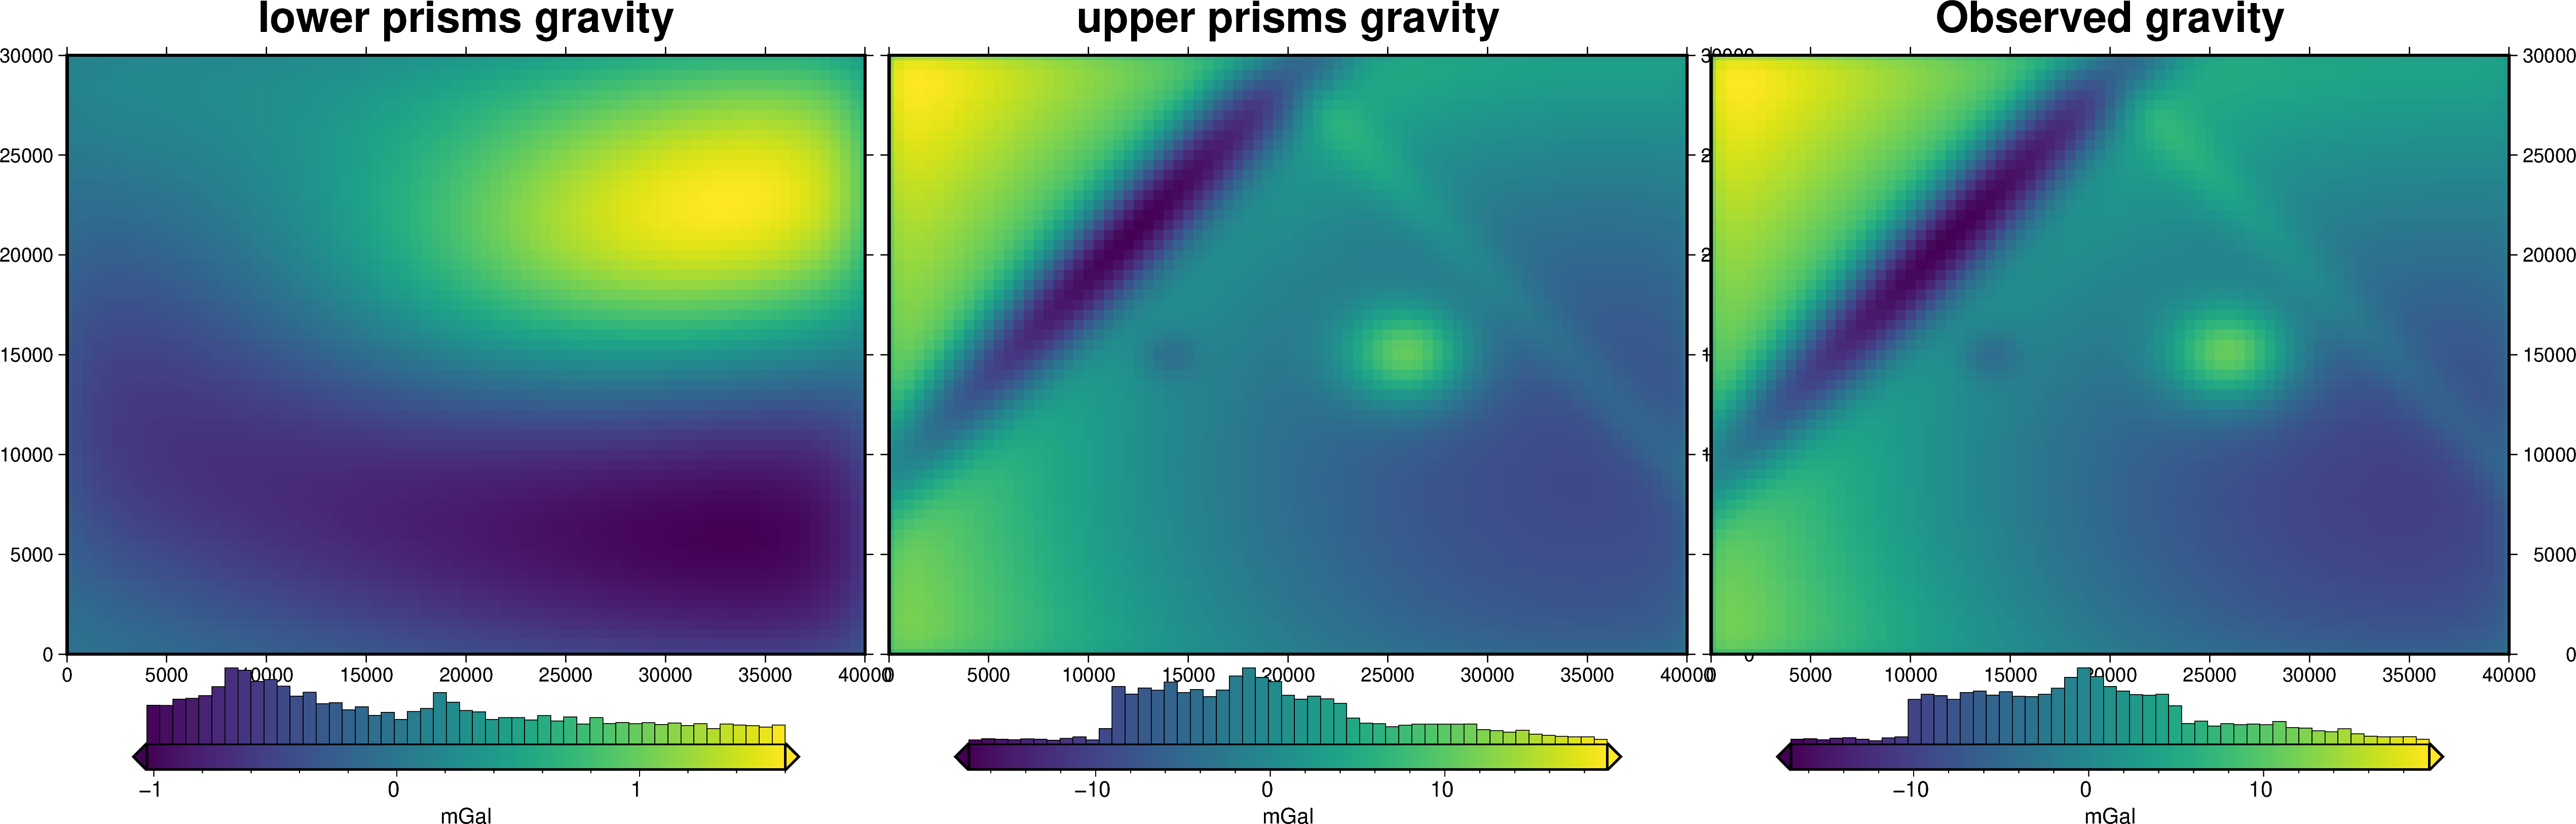

In [13]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.lower_surface_grav,
    fig_height=10,
    title="lower prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.upper_surface_grav,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="upper prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Create "a-priori" topography measurements

In [55]:
# create 25 random point within the outcropping basement region
num_constraints = 25
coords = vd.scatter_points(
    region=vd.pad_region(region, -spacing),
    size=num_constraints,
    random_state=0,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    true_topography,
    "upward",
)
constraint_points.head()

,easting,northing,upward
0,21903.726653,19057.709618,472.843511
1,28392.385289,4657.245335,417.654600
2,24007.771667,27895.398594,537.989827
3,21750.444137,15633.601331,485.088965
4,17022.537174,12525.196260,471.304408


## Create starting model

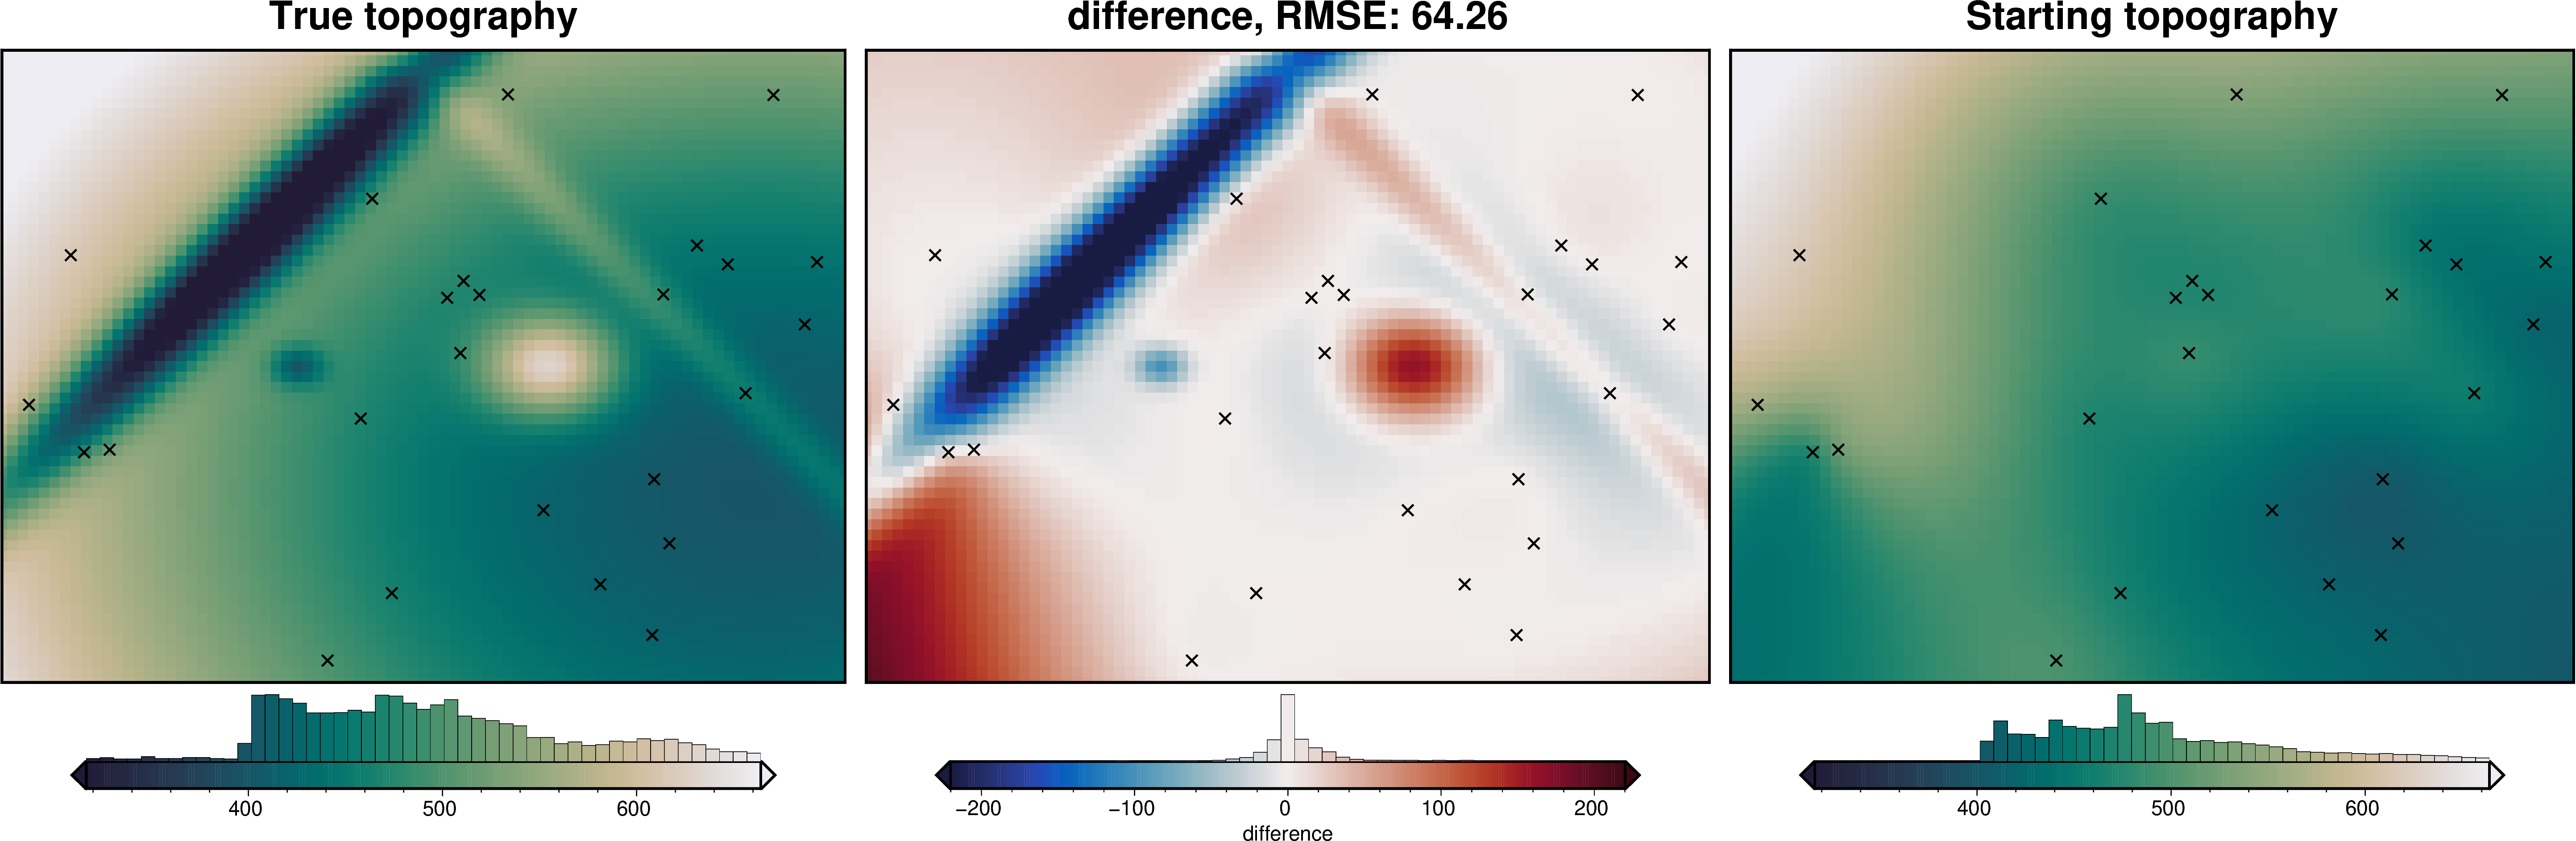

In [65]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=region,
    spacing=spacing,
    constraints_df=constraint_points,
    # dampings=np.logspace(-40, 0, 100),
    dampings=None,
)

starting_topography = utils.create_topography(**starting_topography_kwargs)

_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    region=region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [66]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
)

rmse_starting = utils.rmse(
    constraint_points.upward - constraint_points.starting_topography
)
max_error_starting = vd.maxabs(
    constraint_points.upward - constraint_points.starting_topography
)

print(f"RMSE at constraints: {round(rmse_starting,1)} m")
print(f"max error at constraints: {round(max_error_starting,1)} m")

RMSE at constraints: 0.1 m
max error at constraints: 0.5 m


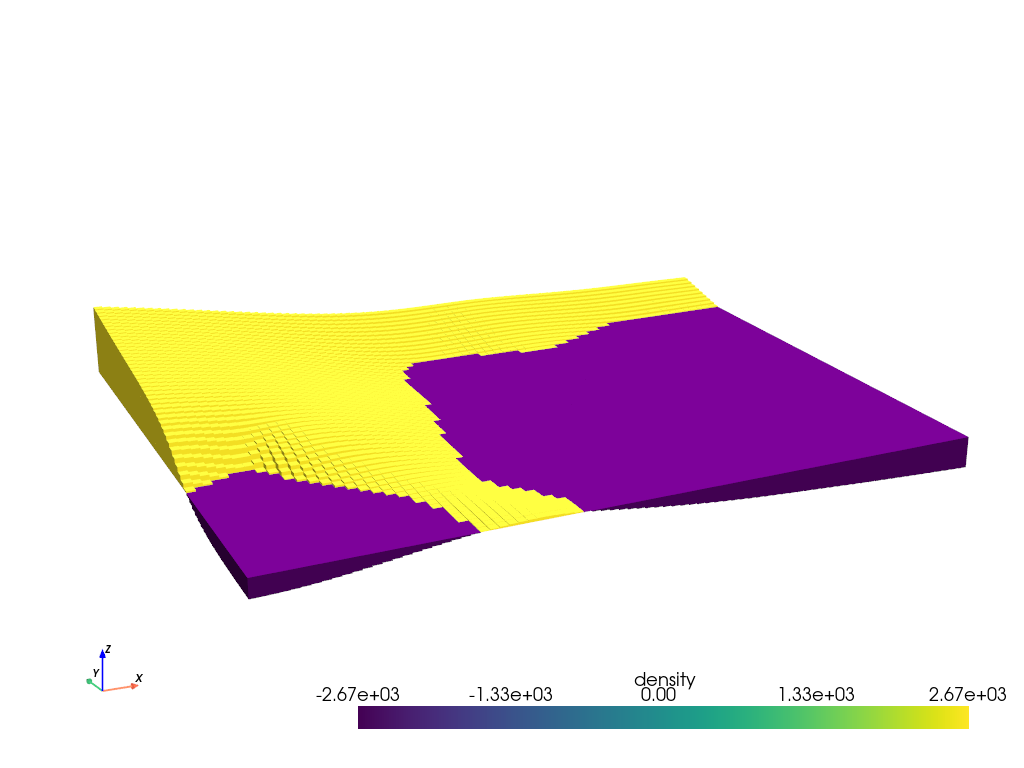

In [67]:
# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= true_zref, true_density_contrast, -true_density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    true_zref,
    density=density_grid,
)
plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

In [68]:
# calculate forward gravity of starting prism layer
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# estimate regional with the median misfit at constraints
grav_df = regional.regional_constant(
    grav_df=grav_df,
    constraints_df=constraint_points,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly,starting_gravity,misfit,reg,res
0,0.0,0.0,1001.0,6.966073,-0.045074,6.920999,-2.369614,9.290613,-0.617017,9.907630
1,0.0,500.0,1001.0,8.535965,-0.049696,8.486269,-2.999030,11.485299,-0.617017,12.102316
2,0.0,1000.0,1001.0,8.802495,-0.055773,8.746722,-3.206840,11.953563,-0.617017,12.570580
3,0.0,1500.0,1001.0,8.723351,-0.063154,8.660197,-3.262863,11.923061,-0.617017,12.540078
4,0.0,2000.0,1001.0,8.519803,-0.071496,8.448307,-3.247334,11.695641,-0.617017,12.312659
...,...,...,...,...,...,...,...,...,...,...
4936,30000.0,38000.0,1001.0,2.832952,0.558197,3.391148,2.628144,0.763004,-0.617017,1.380021
4937,30000.0,38500.0,1001.0,2.816434,0.529278,3.345712,2.567619,0.778092,-0.617017,1.395110
4938,30000.0,39000.0,1001.0,2.765486,0.491156,3.256643,2.473866,0.782777,-0.617017,1.399794
4939,30000.0,39500.0,1001.0,2.607967,0.442645,3.050612,2.288311,0.762301,-0.617017,1.379318


makecpt [ERROR]: Option T: min >= max


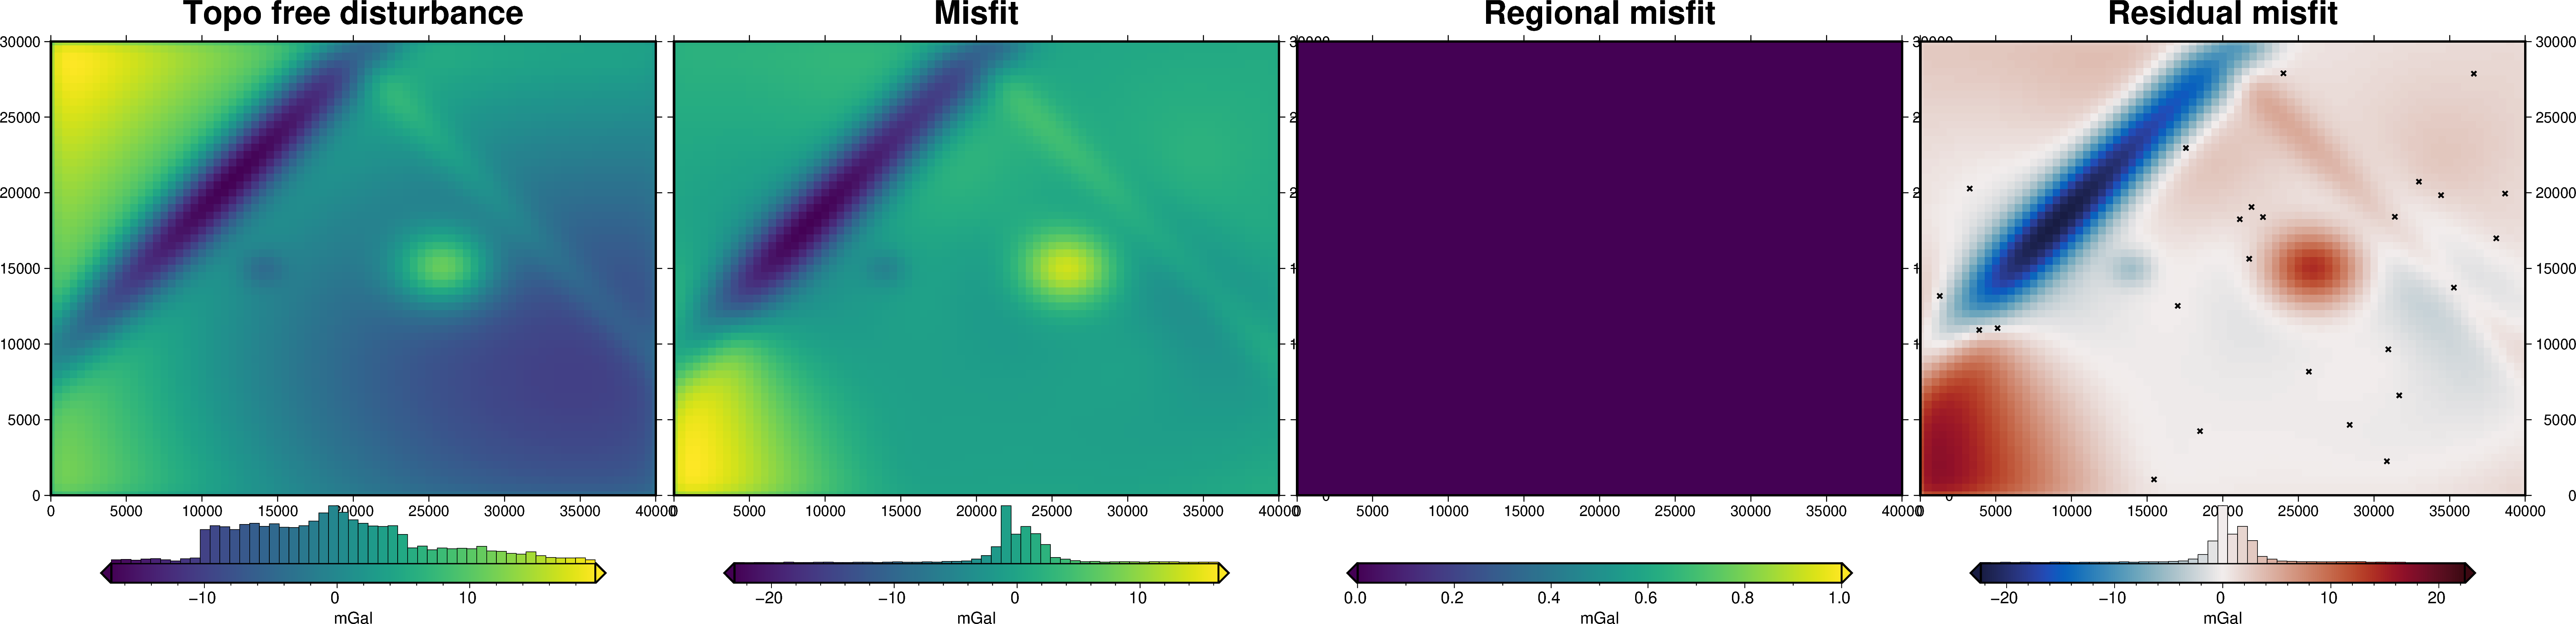

In [69]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="x.15c",
)
fig.show()

## Inversion without weighting grid

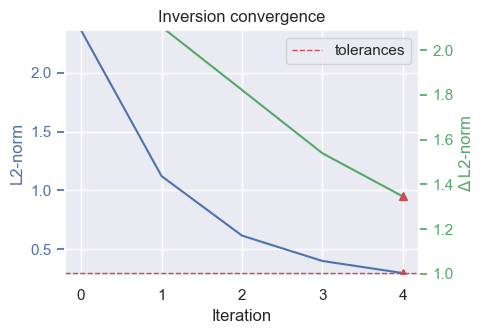

In [70]:
logging.getLogger().setLevel(logging.WARN)

# set kwargs to pass to the inversion
kwargs = {
    "solver_damping": 0.05,
    # set stopping criteria
    "max_iterations": 300,
    "l2_norm_tolerance": 0.3,
    "delta_l2_norm_tolerance": 1.005,
}
# run the inversion workflow
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    fname="../tmp/non_weighted_inversion",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

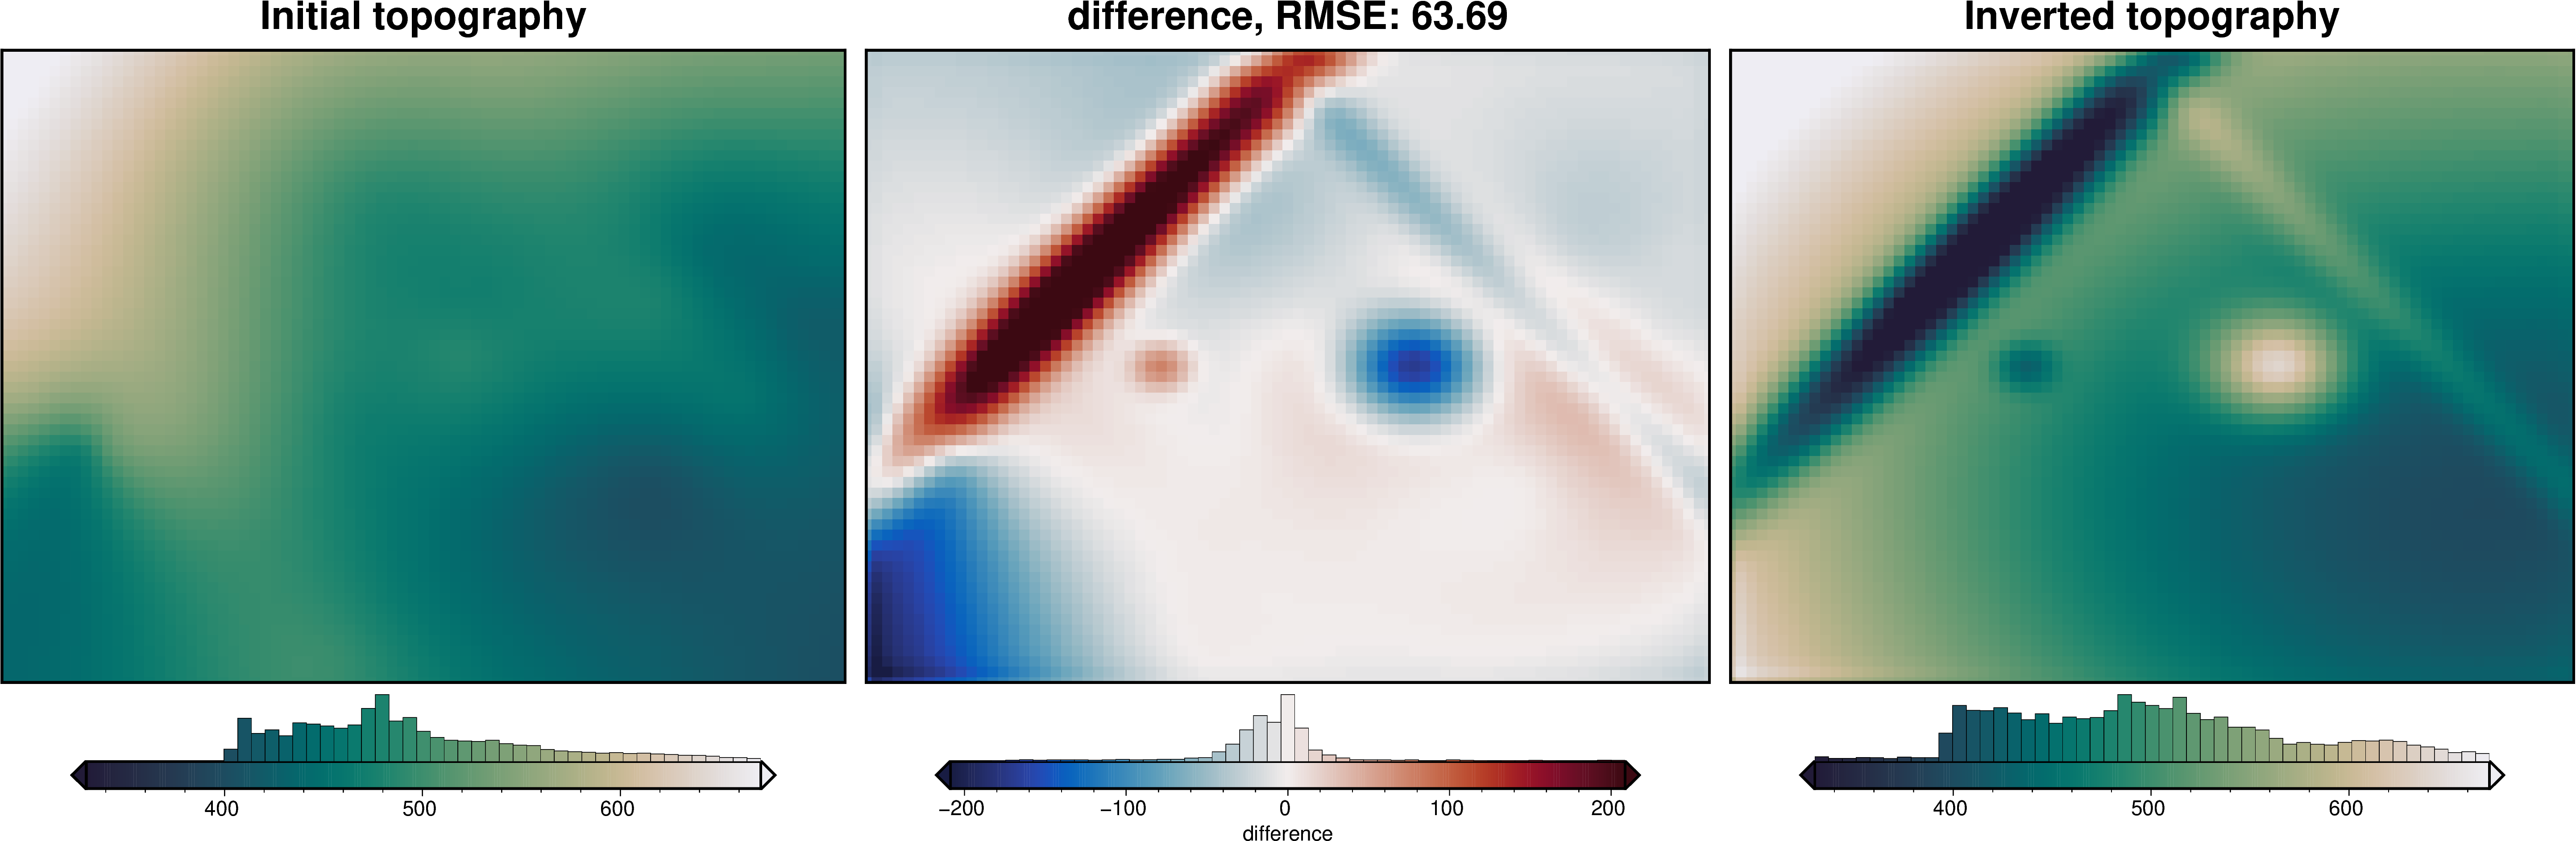

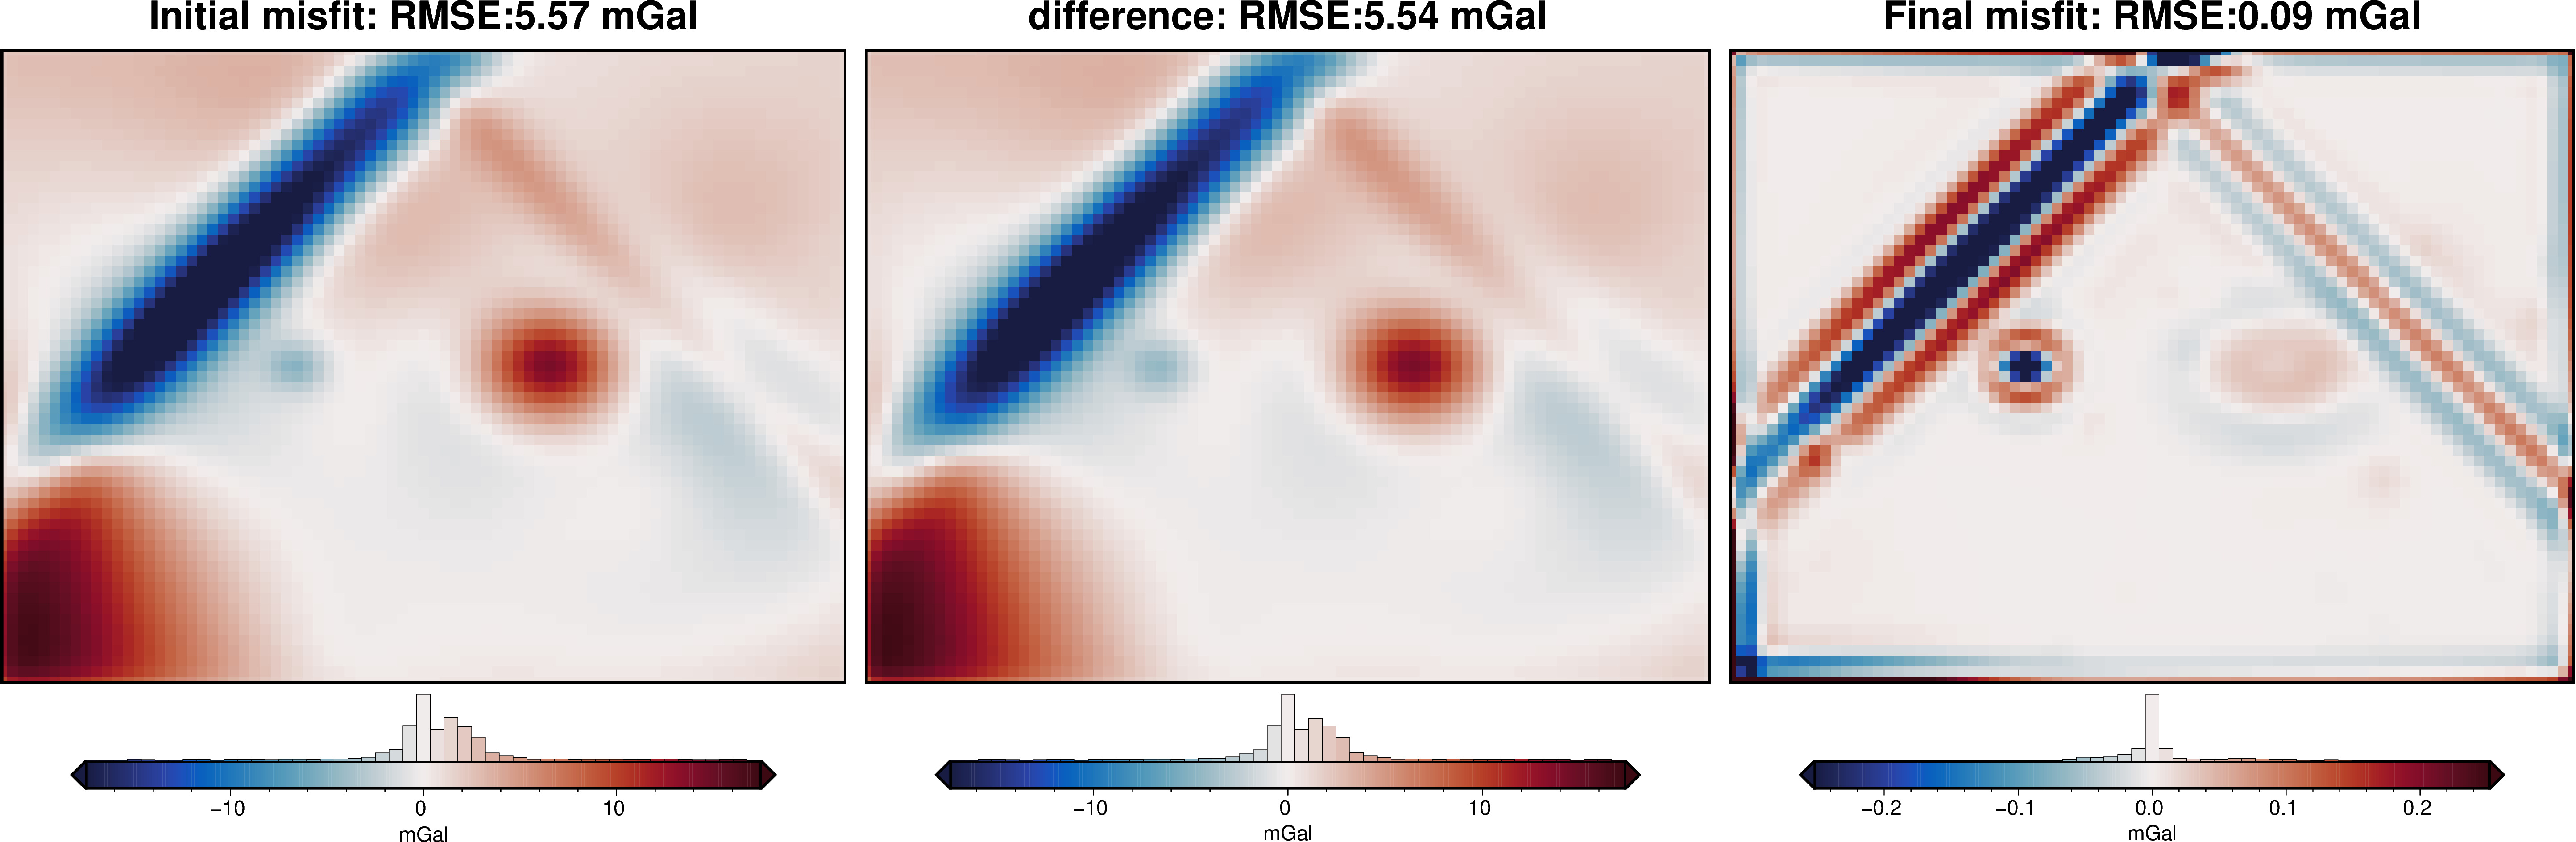

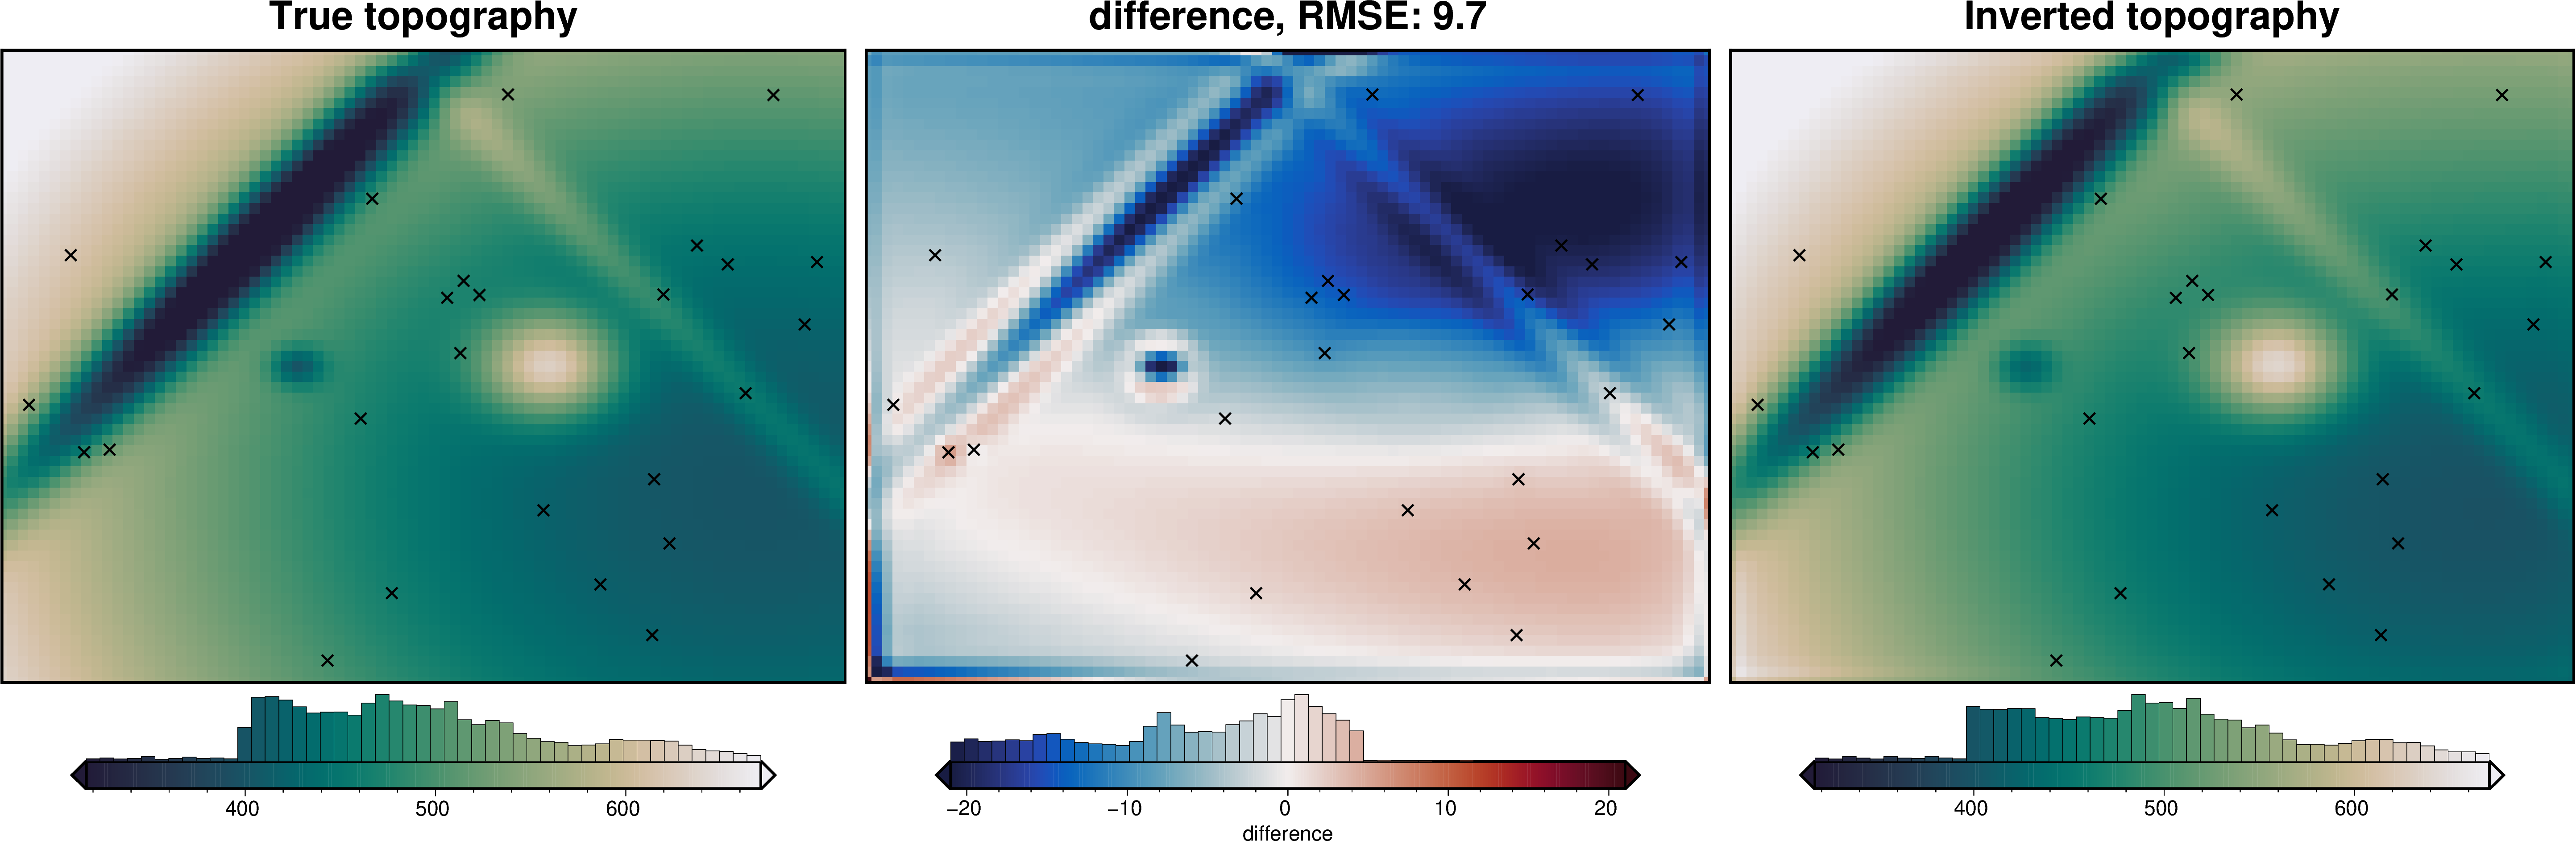

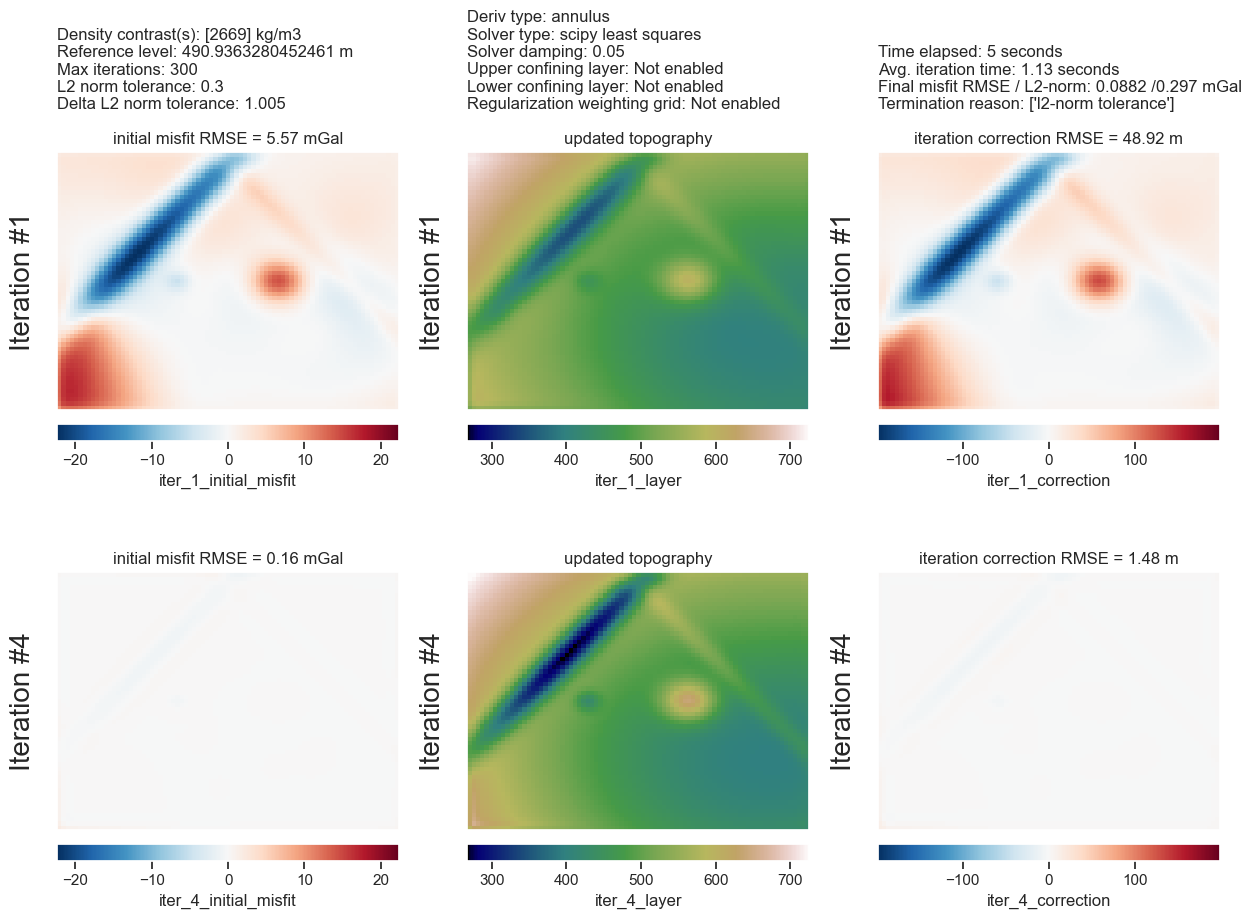

In [71]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [72]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse_without_weighting = utils.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
max_error_without_weighting = vd.maxabs(
    constraint_points.upward - constraint_points.inverted_topography
)

print(f"RMSE at constraints: {round(rmse_without_weighting,1)} m")
print(f"max error at constraints: {round(max_error_without_weighting,1)} m")

RMSE at constraints: 10.6 m
max error at constraints: 20.3 m


## Weighting grid
To force the inversion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

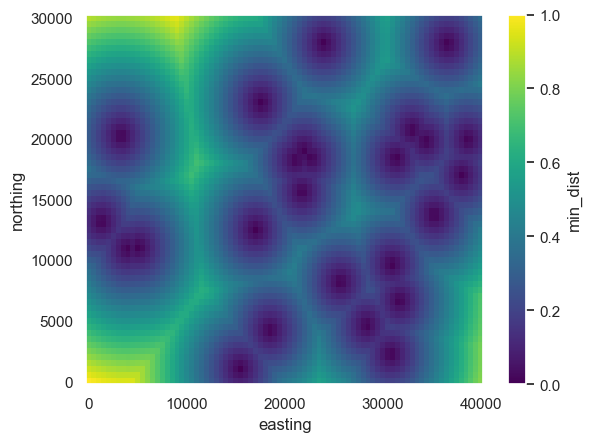

In [73]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
weighting_grid.plot()

## Perform inversion
Now we can perform the inversion, supplying the argument `apply_weighting_grid=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. 

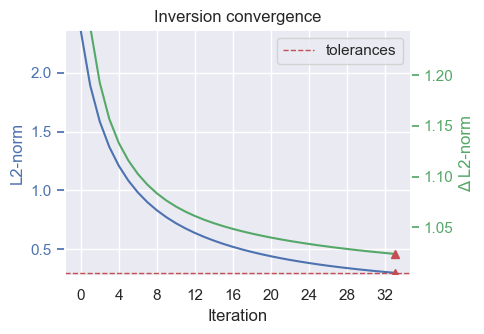

In [74]:
logging.getLogger().setLevel(logging.WARN)

# run the inversion workflow
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    # enable the use of weights
    apply_weighting_grid=True,
    weighting_grid=weighting_grid,
    fname="../tmp/weighted_inversion",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

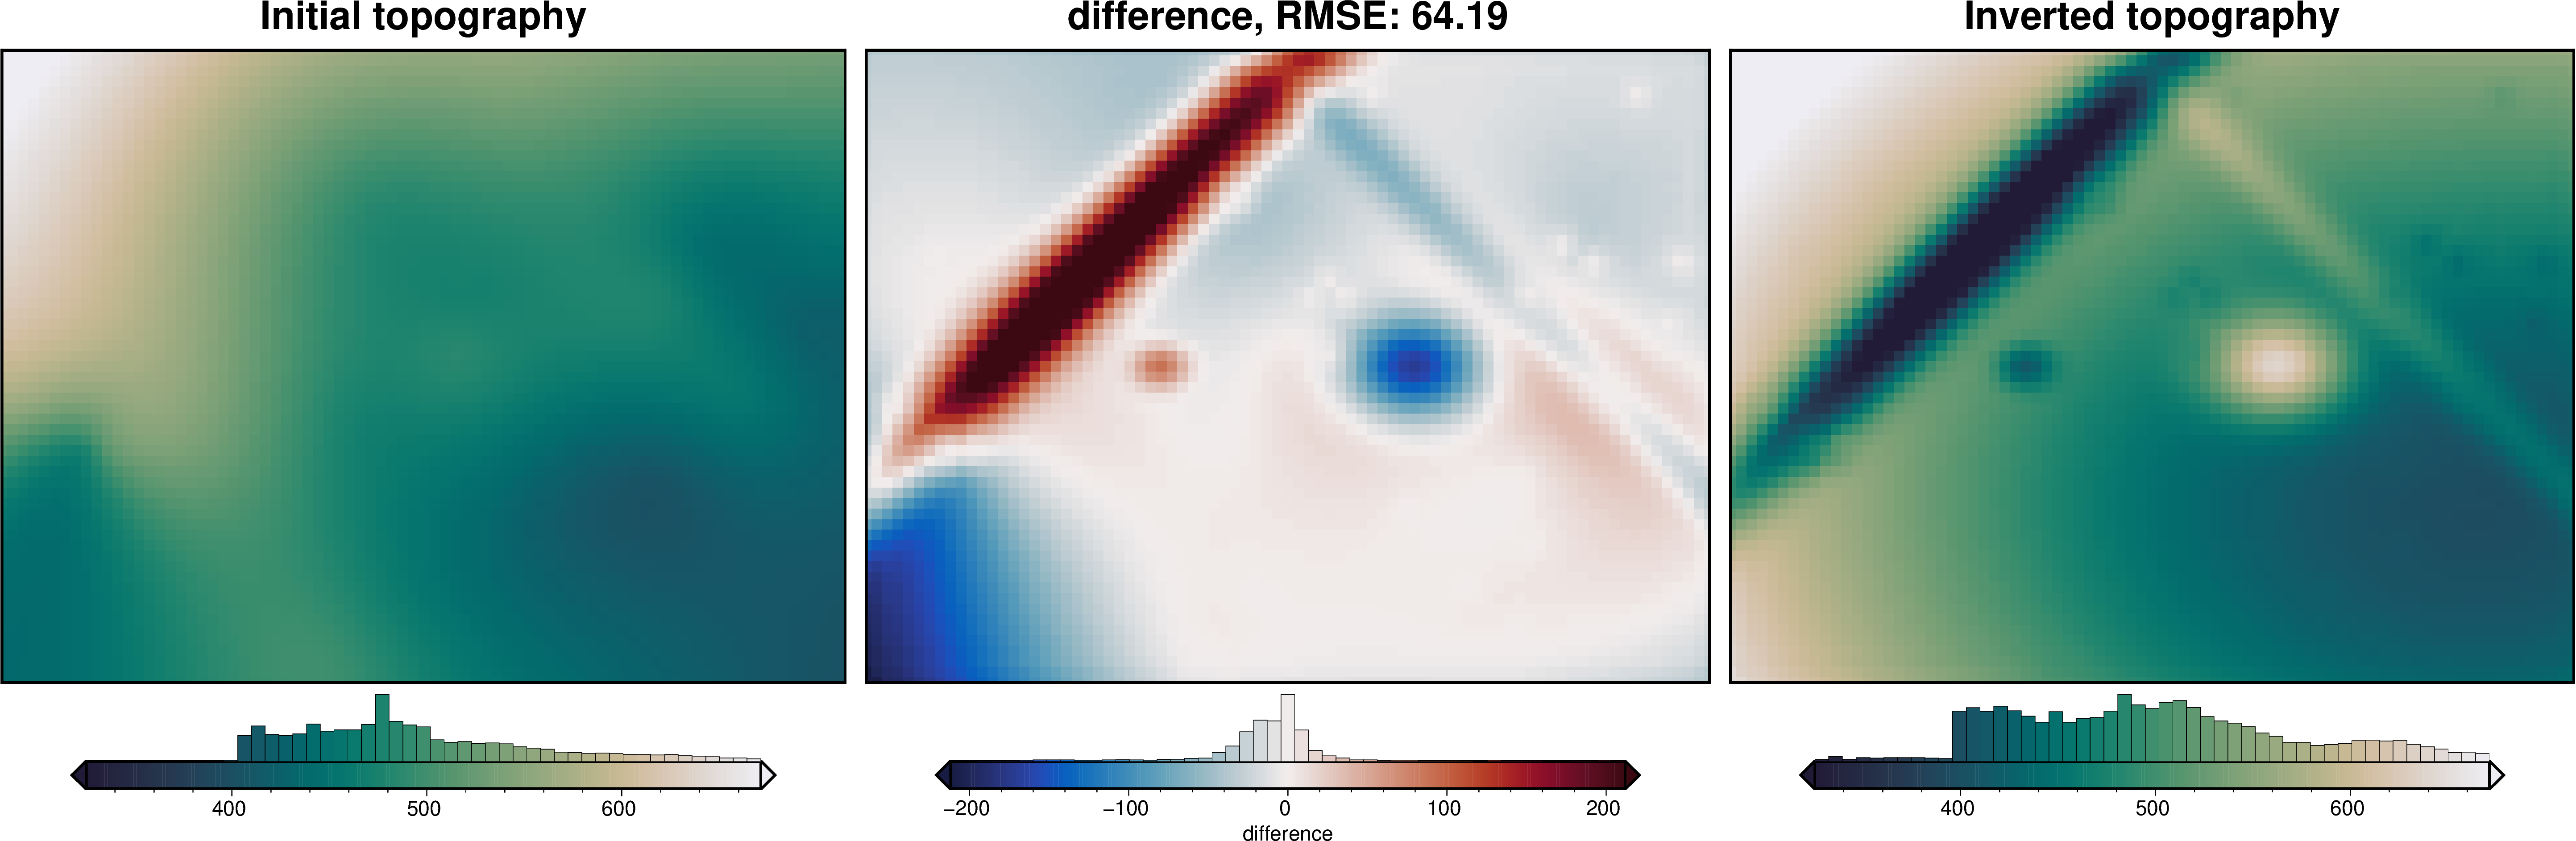

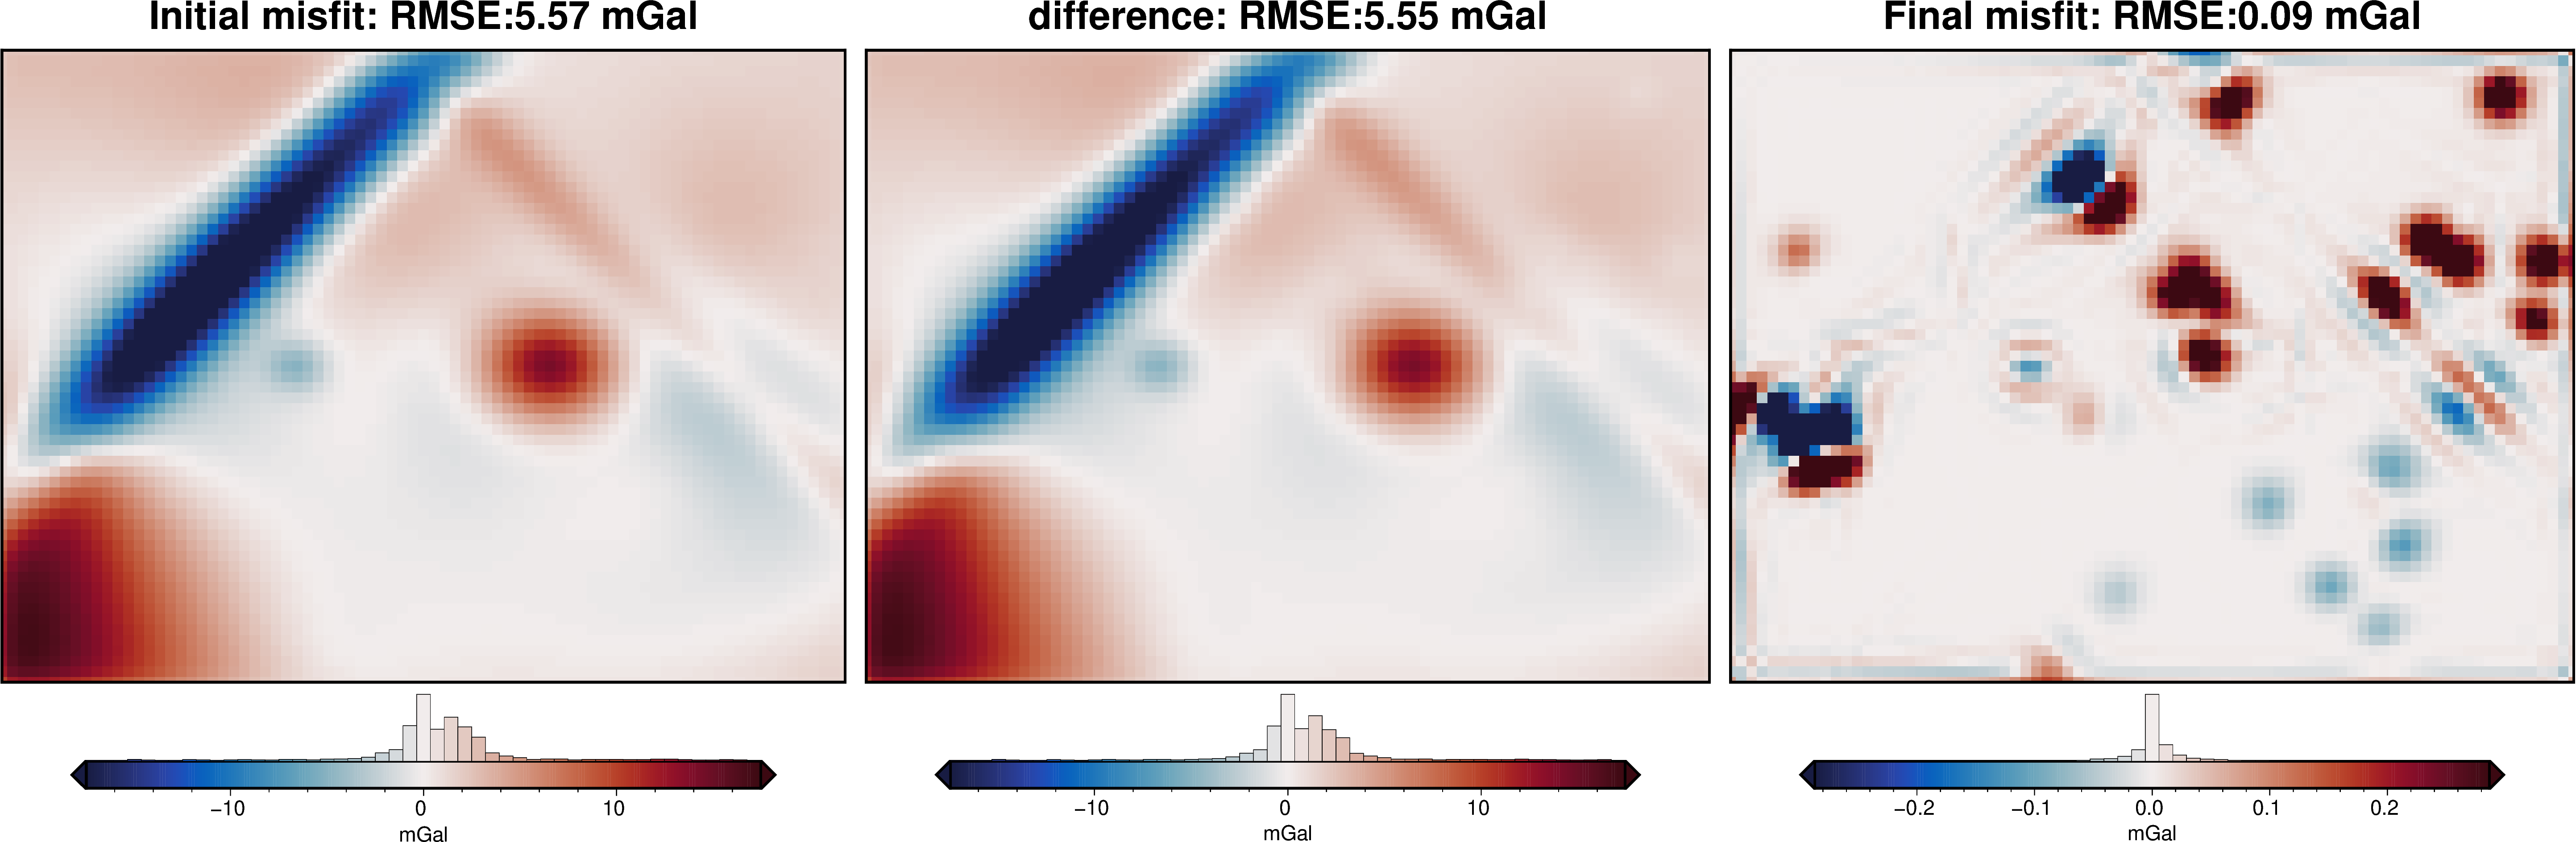

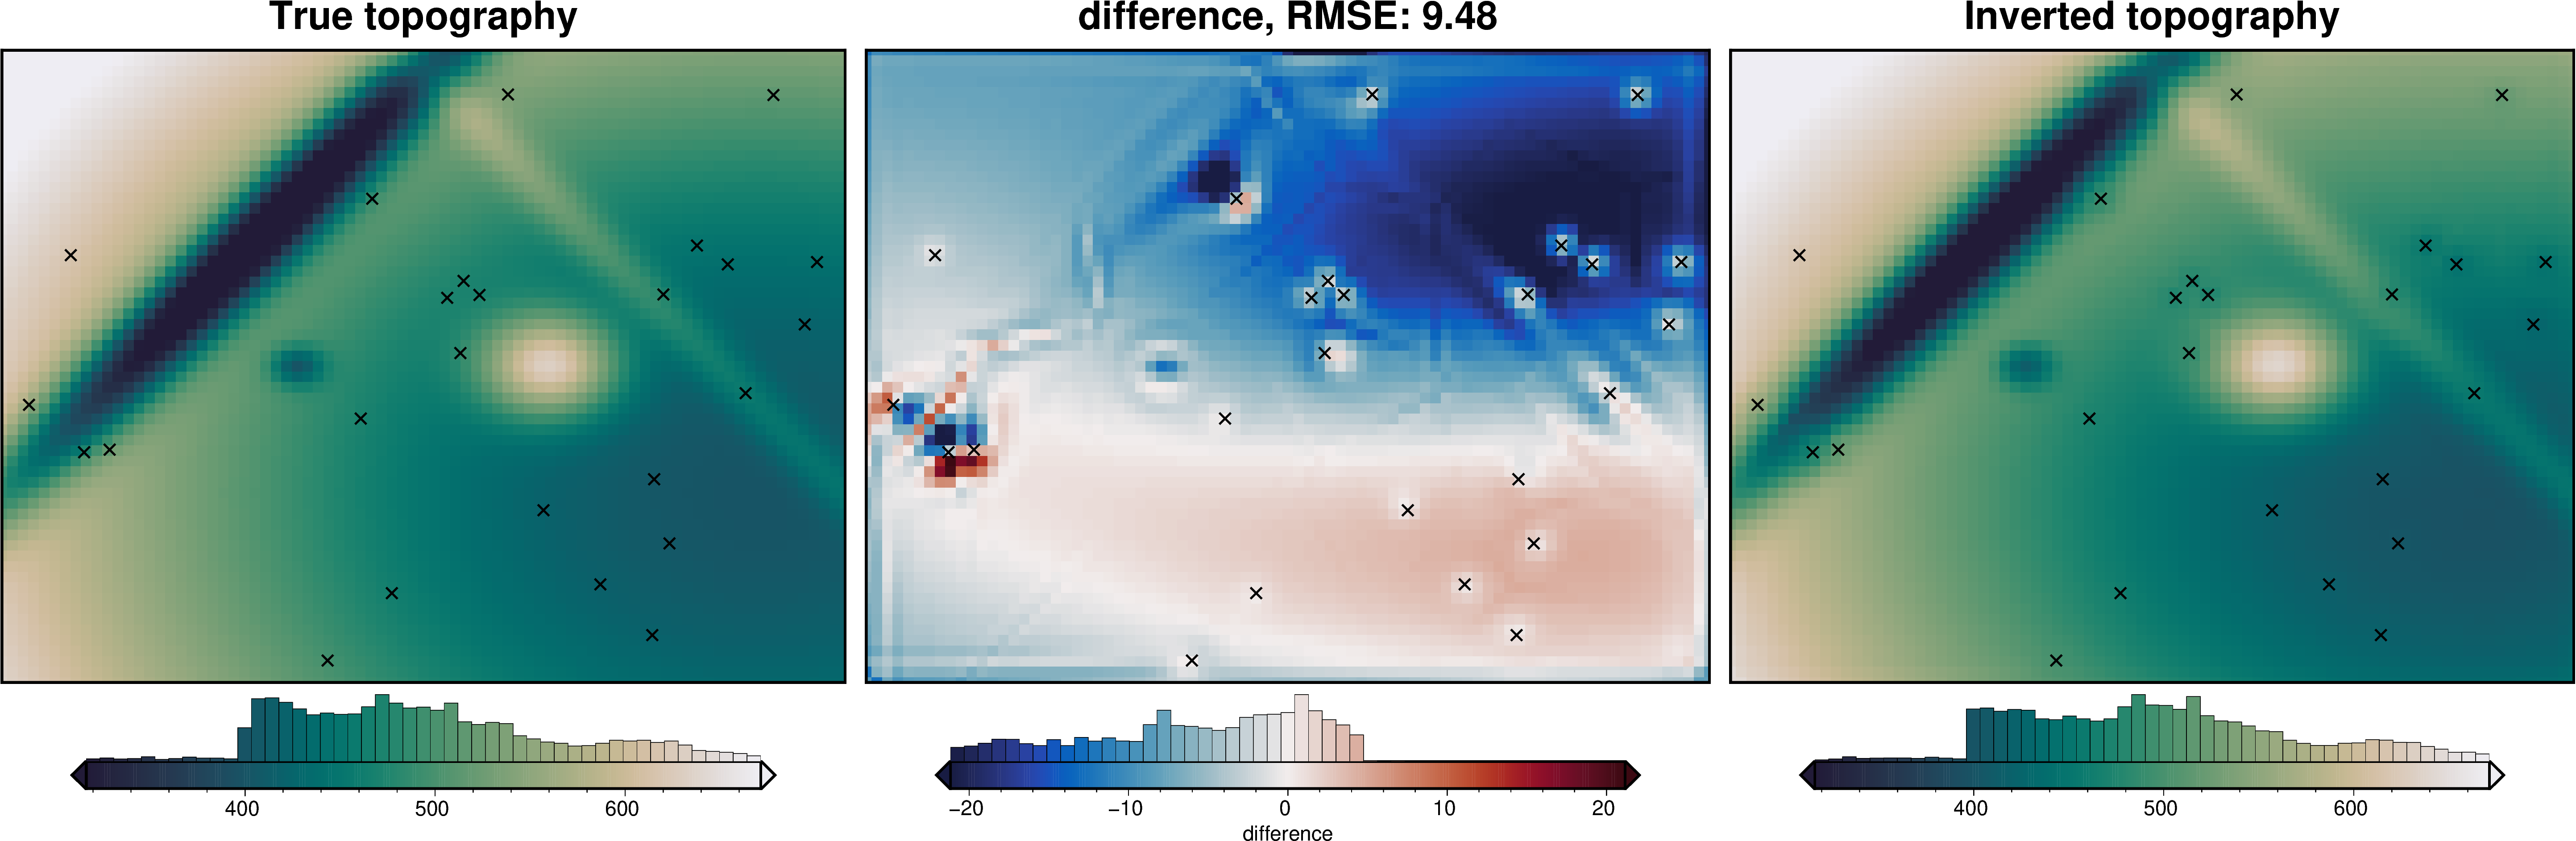

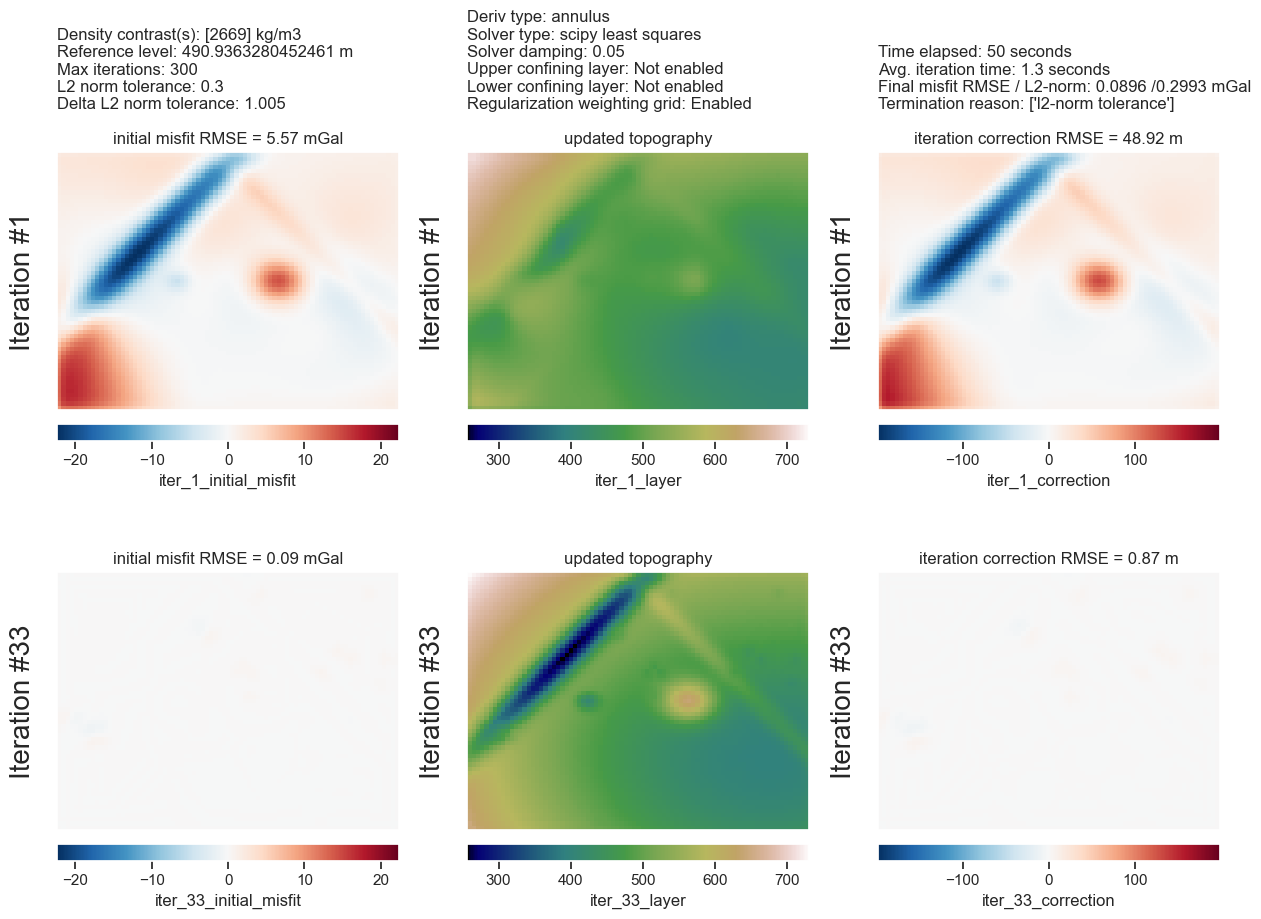

In [75]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

As we can see by the low error values surrounding the constraints (black crosses), include the weighting grid has help the inversion adhere to the constraints. We can sample the inverted topography at the constraints and compare with the constraints true values.

In [78]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse_with_weighting = utils.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
max_error_with_weighting = vd.maxabs(
    constraint_points.upward - constraint_points.inverted_topography
)

print("without weighting:")
print(f"\tRMSE at constraints : {round(rmse_without_weighting,1)} m")
print(f"\tmax error at constraints: {round(max_error_without_weighting,1)} m")

print("with weighting:")
print(f"\tRMSE at constraints: {round(rmse_with_weighting,1)} m")
print(f"\tmax error at constraints: {round(max_error_with_weighting,1)} m")

without weighting:
	RMSE at constraints : 10.6 m
	max error at constraints: 20.3 m
with weighting:
	RMSE at constraints: 2.0 m
	max error at constraints: 4.2 m


While this inversion's results are very similar to the inversion without using the weighting grid, the RMSE at the constraint points has been lowered, showing the inversion is more closely  adhering to these constraints.

Note at we increased the max iterations allowed. This is necessary since with the weighting grid will require many more iterations to get to a similar outcome.

#